In [10]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn as nn
from torch.utils.data import DataLoader
import os
from tqdm.notebook import tqdm
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


In [11]:
RESUME = None # path to checkpoint
EXPORT = 'model.pth'
BATCH_SIZE = 8 
EPOCH = 2
LR = 1e-3

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                            ])
full_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_ds, val_ds = torch.utils.data.random_split(full_ds, [int(len(full_ds)*0.8), int(len(full_ds)*0.2)])

print('The number of training data: ', len(train_ds))
print('The number of validation data: ', len(val_ds))
print('The number of test data: ', len(test_ds))

The number of training data:  48000
The number of validation data:  12000
The number of test data:  10000


In [13]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        # Convolution 1 , input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0) #output_shape=(16,24,24)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,12,12)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(32,8,8)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,4,4)
        # Fully connected 1 ,#input_shape=(32*4*4)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [14]:
import matplotlib.pyplot as plt
# plot loss curve
def plot_loss_curve(history):
    plt.cla()
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('valid_loss') for x in history]
    plt.plot(train_losses, '-bx',label='train')
    plt.plot(val_losses, '-rx',label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend()
    plt.savefig('loss_curve.png')
# plot accuracy curve
def plot_accuracy_curve(history):
    plt.cla()
    psnrs = [x.get('accuracy') for x in history]
    plt.plot(psnrs, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy vs. No. of epochs');
    plt.savefig('accuracy.png')
# plot lr curve
def plot_lr_curve(history):
    plt.cla()
    lrs = [x.get('lrs') for x in history]
    plt.plot(lrs, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('lr')
    plt.title('lr vs. No. of epochs');
    plt.savefig('lr_curve.png')

In [15]:
def train():
    history = []
    train_loss = 0
    best_accuracy = 0
    start_epoch = 1
    #loading pretrained models
    if RESUME:
        if os.path.isfile(RESUME):
            print("===> loading models '{}' from".format(RESUME))
            checkpoint = torch.load(RESUME)
            model.load_state_dict(checkpoint['model'])
            start_epoch = checkpoint['epoch']
            best_accuracy = checkpoint['best_accuracy']
            history = checkpoint['history']
            print("checkpoint loaded: epoch = {}, accuracy = {}".format(start_epoch, best_accuracy))
        else:
            print("===> no models found at '{}'".format(args.resume))

    model.train()
    for epoch in range(start_epoch,EPOCH + 1):
        result = {'train_loss': [], 'valid_loss': [], 'lrs': [], 'accuracy': []}
        print('Epoch: {}'.format(epoch))
        print('learning rate: {:.6f}'.format(optimizer.param_groups[0]['lr']))
        for (img,label) in tqdm(train_dl):
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_dl) # average loss per batch
        
        model.eval()
        with torch.no_grad():
            # compute validation loss 
            valid_loss = 0
            for (img,label) in tqdm(valid_dl):
                img = img.to(device)
                label = label.to(device)
                output = model(img)
                loss = criterion(output, label)
                valid_loss += loss.item()
            valid_loss = valid_loss / len(valid_dl) # average loss per batch
            # compute test accuracy
            correct = 0
            for (img,label) in tqdm(test_dl):
                img = img.to(device)
                label = label.to(device)
                output = model(img)
                pred = output.argmax(dim=1, keepdim=True) #returns the index of the maximum value
                correct += pred.eq(label.view_as(pred)).sum().item()
            
        accuracy = correct/len(test_ds)
        result['train_loss'].append(train_loss)
        result['valid_loss'].append(valid_loss)
        result['accuracy'].append(accuracy)
        result['lrs'].append(optimizer.param_groups[0]['lr'])
        print('Train Loss: {:.4f}'.format(train_loss))
        print('Val Loss: {:.4f}'.format(valid_loss))
        print('Test Accuracy: {:.4f}'.format(accuracy))
        history.append(result)

        if accuracy > best_accuracy:
            model_folder = "checkpoint"
            if not os.path.exists(model_folder):
                os.makedirs(model_folder)
            best_accuracy = accuracy
            model_out_path = os.path.join(model_folder, EXPORT)
            state = {"epoch": epoch,
                    "model": model.state_dict(),
                    "best_accuracy": best_accuracy,
                    "history": history}
            torch.save(state, model_out_path)
            print("===> Checkpoint saved to {}".format(model_out_path))

        plot_loss_curve(history)
        plot_accuracy_curve(history)
        plot_lr_curve(history)

Epoch: 1
learning rate: 0.001000


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.1370
Val Loss: 0.0523
Test Accuracy: 0.9846
===> Checkpoint saved to checkpoint/model.pth
Epoch: 2
learning rate: 0.001000


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0509
Val Loss: 0.0489
Test Accuracy: 0.9865
===> Checkpoint saved to checkpoint/model.pth


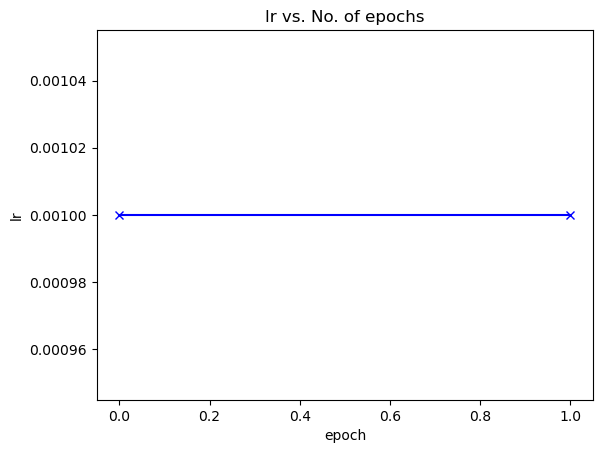

In [16]:
# dataloader
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,num_workers=6, shuffle=True,drop_last=True)
valid_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=6,drop_last=True)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True,num_workers=1,drop_last=True)
# model
model = net().to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train()
traced_model = torch.jit.trace(model, torch.randn(1, 1, 28, 28).to(device)) # replace the argument of torch.randn with the input size of your model
torch.jit.save(traced_model, "demo.pth")

accuracy: 16 out of 16


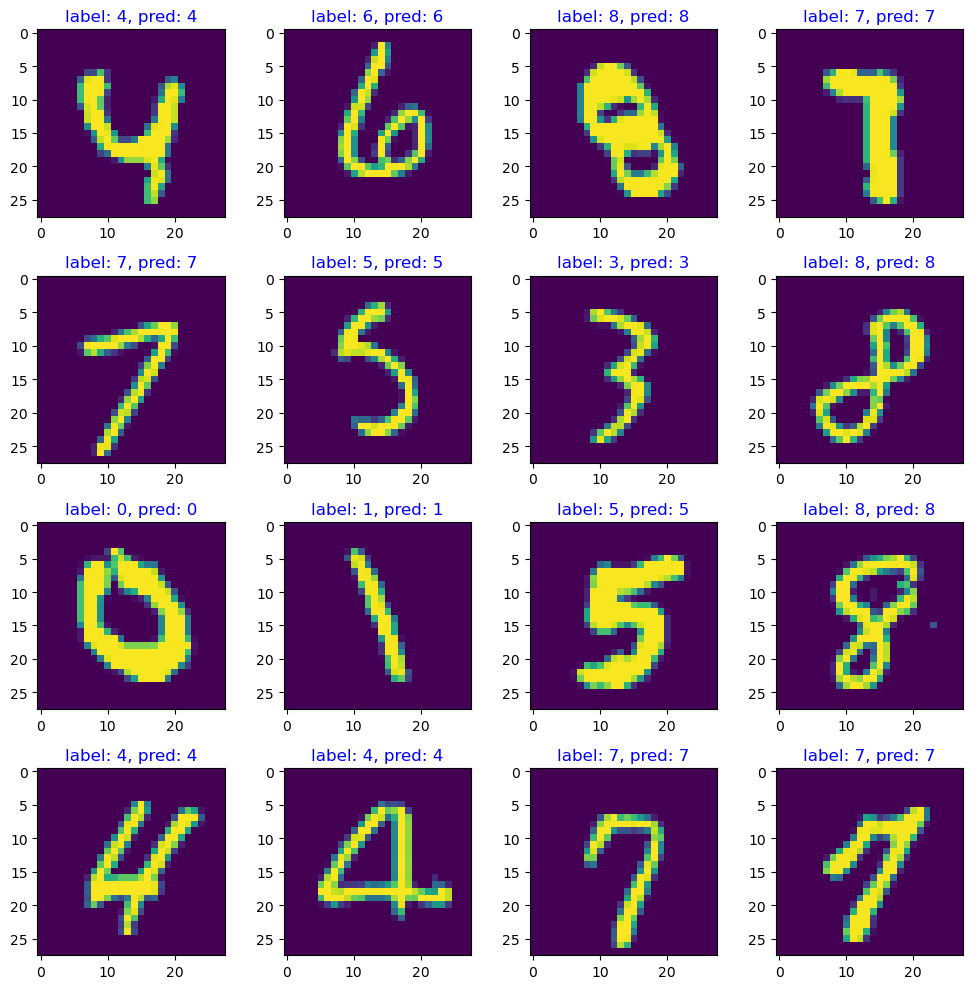

In [17]:
# model = net()
# model.load_state_dict(torch.load('checkpoint/model.pth')['model'])

loaded_model = torch.jit.load("demo.pth")

def show_results(imgs, labels, preds):
    num_imgs = len(imgs)
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    correct = 0
    for i in range(num_imgs):
        row = i // 4
        col = i % 4
        axs[row, col].imshow(imgs[i].permute(1, 2, 0))
        label = labels[i].item()
        pred = preds[i].item()
        correct += (label == pred)
        axs[row, col].set_title('label: {}, pred: {}'.format(label, pred),color='r' if label != pred else 'b')
    plt.tight_layout()
    plt.savefig('results.png')
    print('accuracy: {} out of {}'.format(correct, num_imgs))
    
for img,label in test_dl:
        output = model(img)
        pred = output.argmax(dim=1, keepdim=True)
        show_results(img, label,pred)
        break